<div style="max-width:66ch;">

# Lecture notes - Transfer learning CNN

This is the lecture note for **transfer learning**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to transfer learning. I encourage you to read further about transfer learning. </p>

Read more:

- [Transfer learning wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)
- [Transfer learning on tf_flower - Nutan (2021) medium](https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc)
- [Know Your Data](https://knowyourdata-tfds.withgoogle.com/#dataset=tf_flowers&tab=DATASETS)
- [tf_flowers dataset - TensorFlow](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- [TensorSpec object - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/TensorSpec?version=nightly)
- [Image data preprocessing - TensorFlow](https://link)
- [transfer learning flower set- towardsdatascience](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [ImageNet](https://www.image-net.org/index.php)
- [Keras applications](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
- [Remove layers keras - stackoverflow](https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights)

</div>


<div style="max-width:66ch;">

## Flower dataset

In this lecture we'll move on to working with core tensorflow and their objects. Data will come from tensorflow_datasets

</div>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

(train, test), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info= True
)

info

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteX3MWCL',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [2]:
label_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

img shape: (333, 500, 3), label: 2
img shape: (212, 320, 3), label: 3
img shape: (240, 320, 3), label: 3
img shape: (240, 320, 3), label: 4
img shape: (317, 500, 3), label: 3
img shape: (212, 320, 3), label: 0
img shape: (240, 240, 3), label: 0
img shape: (333, 500, 3), label: 0


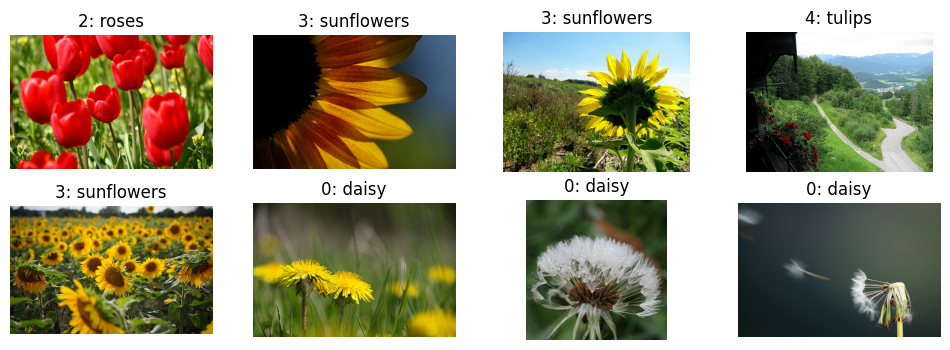

In [3]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
    print(f"img shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis("off")

<div style="max-width:66ch;">

## Preprocessing

- need to reshape the images
- scale them
- create batches 
- optimize performance utilizing CPU and GPU with prefetching a batch

</div>

In [4]:
def preprocess_images(img, label, img_shape = (120, 120)):
    img = tf.image.resize(img, img_shape)/255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

# prefetch always get one batch of data ready 
# GPu work on backpropagation and forward propagation while CPU works on preprocessing a batch
train_batch = train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1)
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)

test_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<div style="max-width:66ch;">

## Transfer learning

There are a few approaches to transfer learning and the approach we're using in this lecture is: 

1. Load a model which has been pretrained on a large dataset e.g. imagenet. 
2. Remove the top, i.e. the classifier part and MLP part
3. Freeze the layers weights of the pretrained network. Reason for this is to use the pretrained weights to extract feature maps from new images which it hasn't seen before. 
4. Add an MLP part and classifier part. Train the data on the last part. 

Idea behind this is that we can reuse a network that is trained on large dataset as many kernels such as edge detectors, simple shape detectors can be used on other datasets as well. Also this is cheap as it is more data-expensive and computationally expensive to train a large network from scratch.

However some deeper layers extract more and more complicated structures that may be too specific for another dataset. Then another approach is to use the shallower layers for feature extraction and train the new dataset on the deeper layers to fine-tune the network. Then add an MLP part as in above. 

</div>

In [5]:
from tensorflow.keras.applications import Xception

feature_extractor = Xception(weights = "imagenet", include_top = False, input_shape = (input_shape))
feature_extractor.summary()


83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 59, 59, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 59, 59, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [6]:
# we see that the layers are trainable by default
print([layer.trainable for layer in feature_extractor.layers])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

model = Sequential(
    [
        feature_extractor,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ]
)

# we freeze the layers of the pretrained model
for layer in feature_extractor.layers:
    layer.trainable = False
    
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                        

In [8]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
92/92 [==============================] - 10s 50ms/step - loss: 0.9690 - acc: 0.6400 - val_loss: 0.5757 - val_acc: 0.8011
Epoch 2/20
92/92 [==============================] - 3s 31ms/step - loss: 0.6560 - acc: 0.7558 - val_loss: 0.5178 - val_acc: 0.8215
Epoch 3/20
92/92 [==============================] - 3s 32ms/step - loss: 0.5783 - acc: 0.7963 - val_loss: 0.4793 - val_acc: 0.8351
Epoch 4/20
92/92 [==============================] - 3s 32ms/step - loss: 0.5104 - acc: 0.8038 - val_loss: 0.4874 - val_acc: 0.8365
Epoch 5/20
92/92 [==============================] - 3s 31ms/step - loss: 0.4813 - acc: 0.8205 - val_loss: 0.4706 - val_acc: 0.8270
Epoch 6/20
92/92 [==============================] - 3s 32ms/step - loss: 0.4531 - acc: 0.8406 - val_loss: 0.4570 - val_acc: 0.8297
Epoch 7/20
92/92 [==============================] - 3s 31ms/step - loss: 0.4311 - acc: 0.8440 - val_loss: 0.4454 - val_acc: 0.8379
Epoch 8/20
92/92 [==============================] - 3s 33ms/step - loss: 0.4016 - 

In [9]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.969025,0.639986,0.575671,0.801090
1,0.655960,0.755790,0.517769,0.821526
2,0.578274,0.796322,0.479251,0.835150
3,0.510444,0.803815,0.487414,0.836512
4,0.481342,0.820504,0.470596,0.826975


<Axes: >

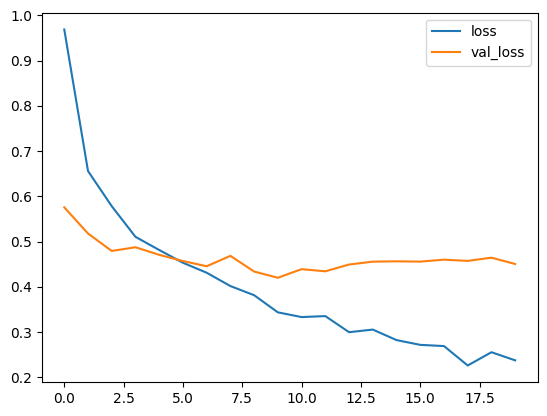

In [10]:
metrics[["loss", "val_loss"]].plot()

<Axes: >

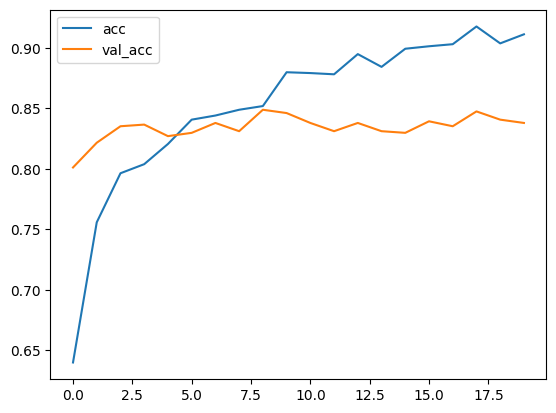

In [11]:
metrics[["acc", "val_acc"]].plot()

<div style="max-width:66ch;">

## Summary

In this lecture we've covered transfer learning where we used a pretrained network, removed its classifier part, froze its weights and then added on an MLP part which we used for fine tuning on our dataset. This is a very common approach that is both performant and very efficient as most of the weights are already trained. 

</div>

<div style="background-color: #FFF; color: #212121; border-radius: 1px; width:22ch; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px; display: flex; justify-content: center; align-items: center;">
<div style="padding: 1.5em 0; width: 70%;">
    <h2 style="font-size: 1.2rem;">Kokchun Giang</h2>
    <a href="https://www.linkedin.com/in/kokchungiang/" target="_blank" style="display: flex; align-items: center; gap: .4em; color:#0A66C2;">
        <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="20"> 
        LinkedIn profile
    </a>
    <a href="https://github.com/kokchun/Portfolio-Kokchun-Giang" target="_blank" style="display: flex; align-items: center; gap: .4em; margin: 1em 0; color:#0A66C2;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> 
        Github portfolio
    </a>
    <span>AIgineer AB</span>
<div>
</div>
